In [54]:
import torch
from pathlib import Path
import os
import random
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.auto import tqdm
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
image_data = Path("D:\CSM character classifier\data")
labels = ['Aki', "Denji", "Makima", "Power"]
for path, dirnames, filenames in os.walk(image_data):
    print(f"There are {len(dirnames)} files, {len(filenames)} images a in {path}")

There are 2 files, 0 images a in D:\CSM character classifier\data
There are 4 files, 0 images a in D:\CSM character classifier\data\Test data
There are 0 files, 94 images a in D:\CSM character classifier\data\Test data\Aki
There are 0 files, 56 images a in D:\CSM character classifier\data\Test data\Denji
There are 0 files, 95 images a in D:\CSM character classifier\data\Test data\Makima
There are 0 files, 100 images a in D:\CSM character classifier\data\Test data\Power
There are 4 files, 0 images a in D:\CSM character classifier\data\Train data
There are 0 files, 500 images a in D:\CSM character classifier\data\Train data\AKI
There are 0 files, 499 images a in D:\CSM character classifier\data\Train data\Denji
There are 0 files, 500 images a in D:\CSM character classifier\data\Train data\Makima
There are 0 files, 498 images a in D:\CSM character classifier\data\Train data\Power


In [56]:
train_path = image_data/"Train data"
test_path = image_data/'Test data'

In [57]:
image_path_list = []
image_path_list.extend(list(image_data.rglob("*.jpg")))
image_path_list.extend(list(image_data.rglob("*.png")))

len(image_path_list)

2112

image path:  D:\CSM character classifier\data\Train data\Denji\denji_solo_460.jpg
image width:  1864
image height:  2126


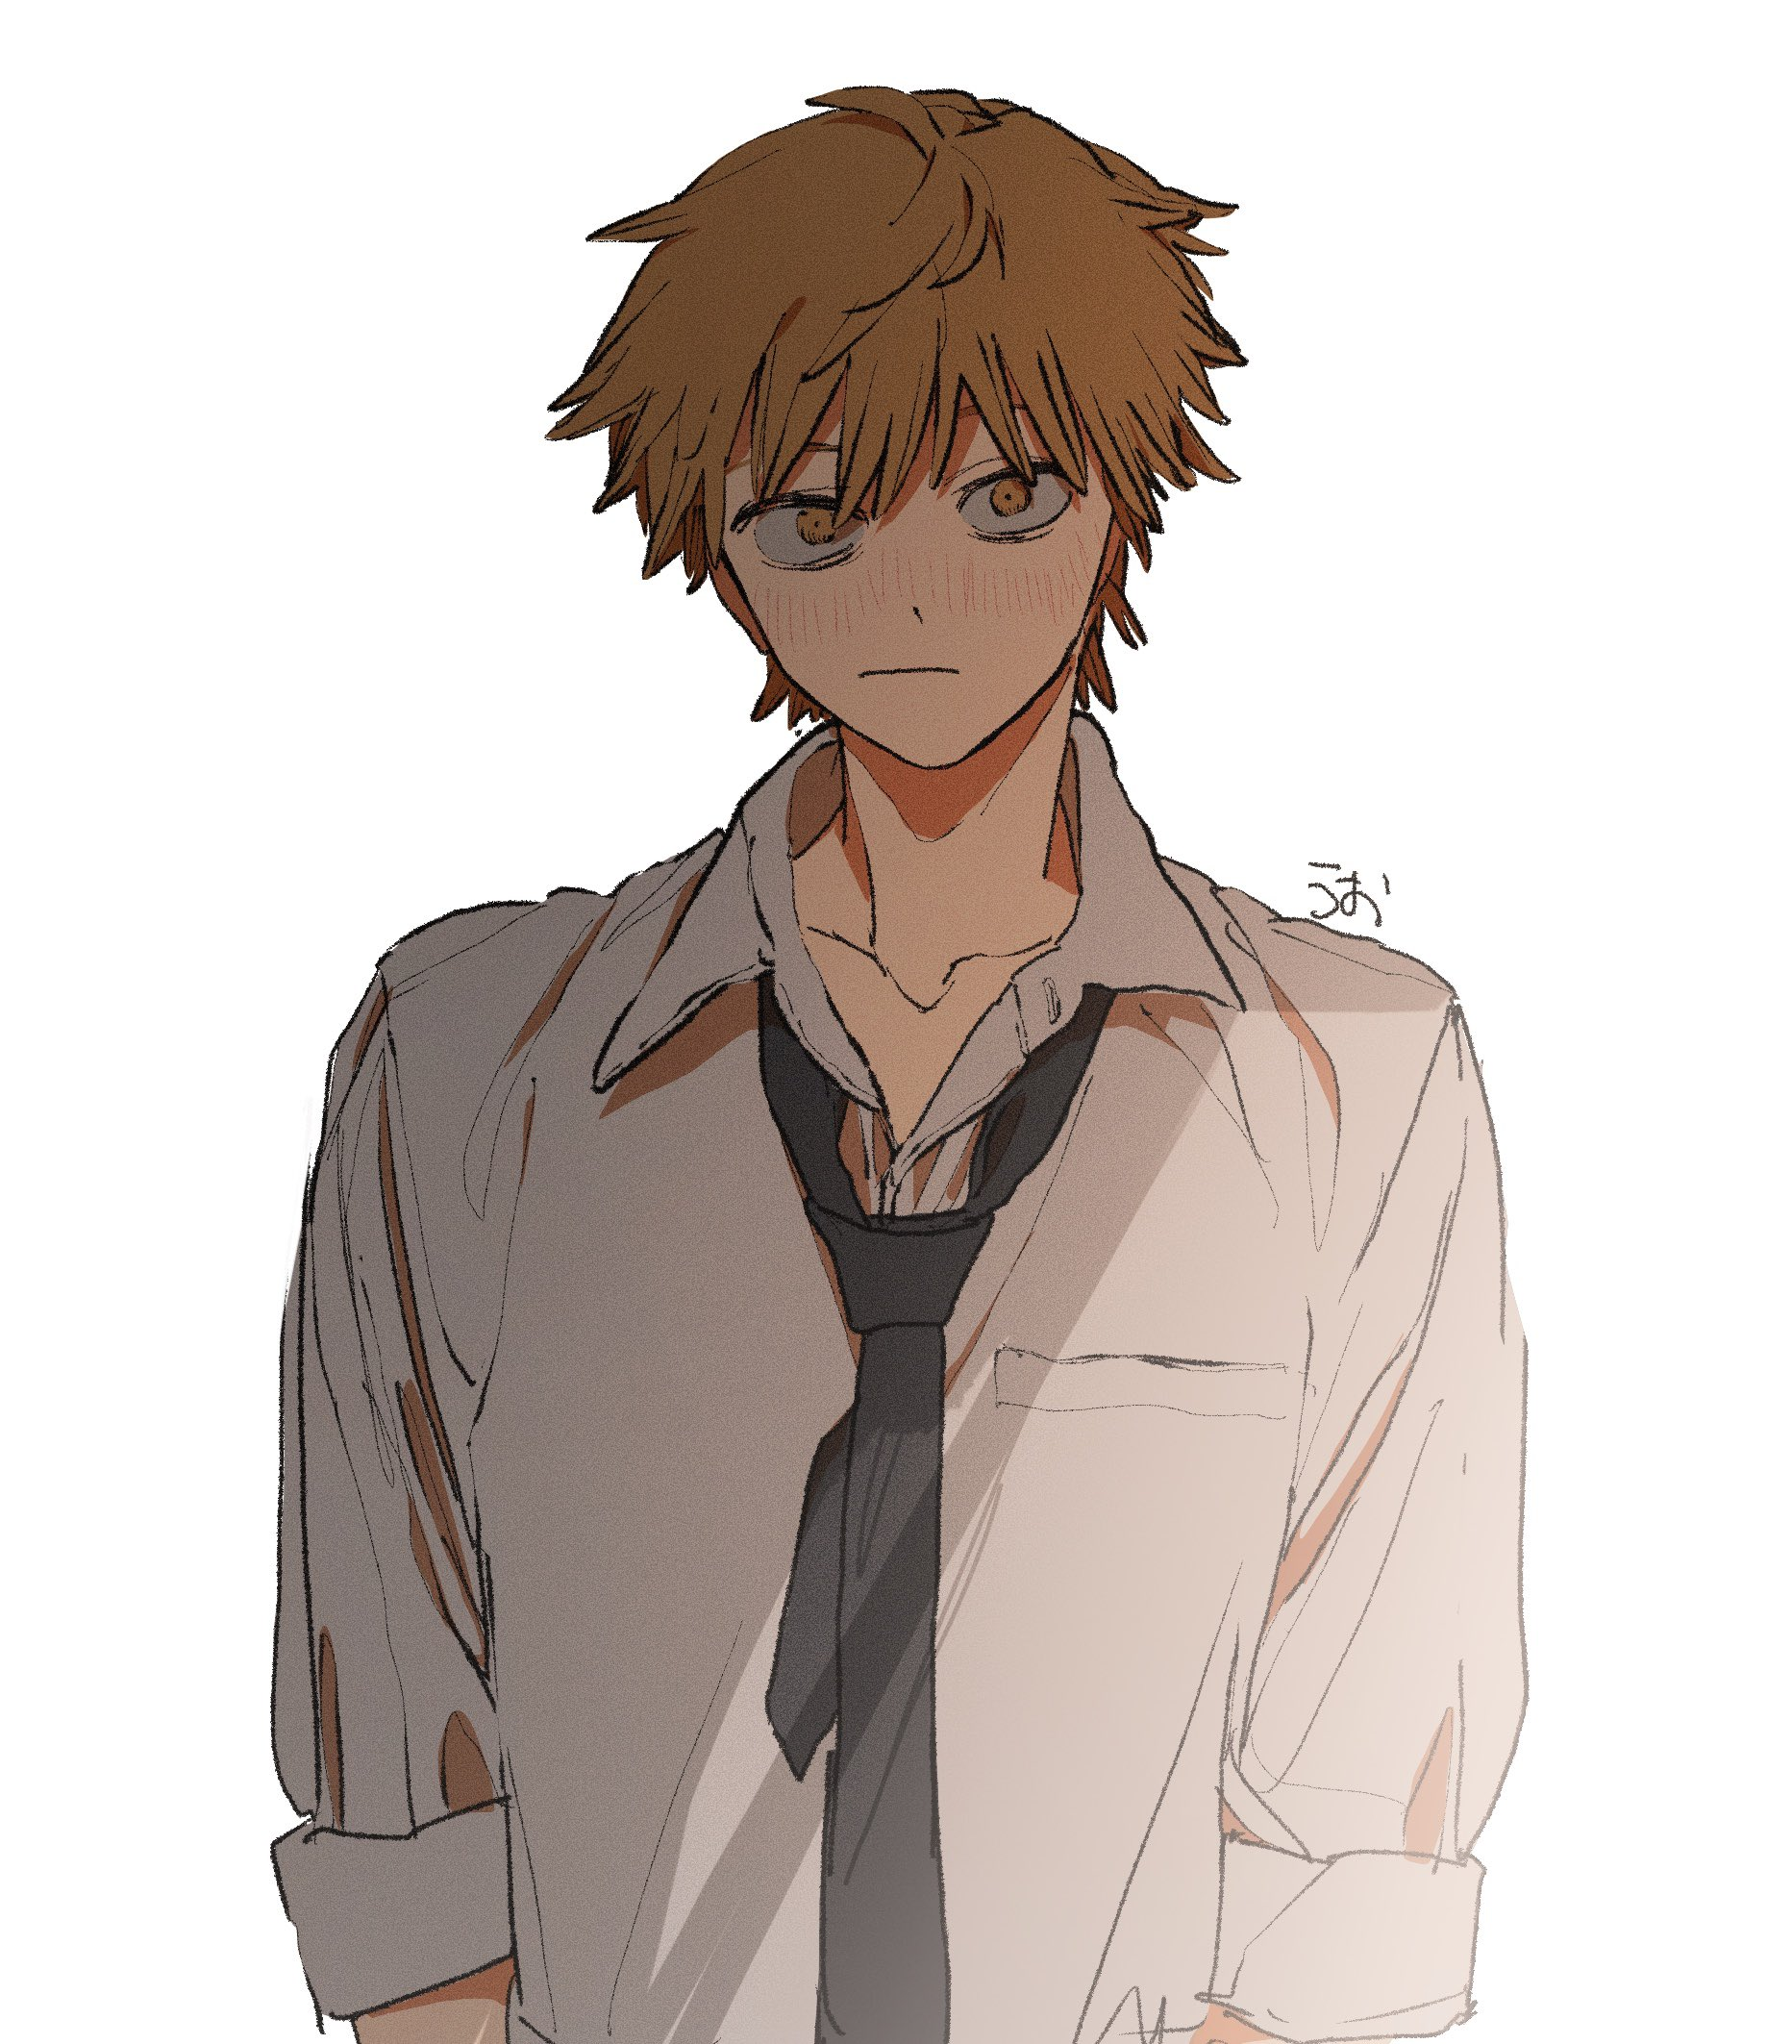

In [58]:
random_image_path = random.choice(image_path_list)
img_rand = Image.open(random_image_path)
print("image path: ", random_image_path)
print("image width: ", img_rand.width)
print("image height: ", img_rand.height)
img_rand

In [59]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),                           # Keep angle small
    #transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),              # Slight jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) 
])

train_dataset = ImageFolder(train_path, transform=train_transform)
test_dataset = ImageFolder(test_path, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [60]:
img, l = next(iter(train_loader))

imgs =img[0].permute(1, 2, 0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Power


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

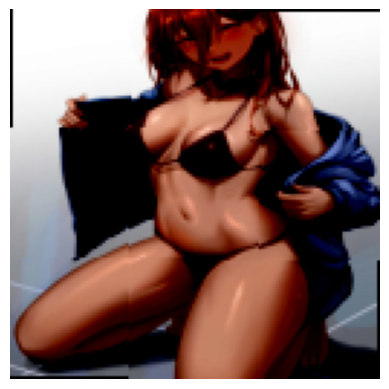

In [61]:
print(labels[l[0]])
plt.imshow(imgs)
plt.axis(False)

In [67]:
model0 = models.resnet18(pretrained=True)

for param in model0.parameters():
    param.requires_grad = False

for name, param in model0.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

model0.fc = nn.Linear(model0.fc.in_features, 4)
model0 = model0.to(device=device)

optimizer = torch.optim.AdamW(model0.parameters(), lr=1e-4, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

e:\annaconda\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\annaconda\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
def trainingloop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                  loss_func: torch.nn.modules.loss._Loss, optimize: torch.optim.Optimizer, device: torch.device= device):
    from sklearn.metrics import accuracy_score
    model.train()
    trainloss = 0
    accuracy = 0
    for (x, y) in (dataloader):
        x, y = x.to(device), y.to(device)
        ypred = model(x)
        preds = ypred.argmax(dim=1).cpu()
        loss = loss_func(ypred, y)
        trainacc = accuracy_score(y_true=y.cpu(), y_pred=preds)
        trainloss += loss.item()
        accuracy += trainacc
        
        optimize.zero_grad()

        loss.backward()

        optimize.step()
    trainloss /= len(dataloader)
    accuracy /= len(dataloader)
    print(f"Trainning loss= {trainloss} | Train Accuracy = {accuracy}")
    return trainloss, accuracy


In [64]:
def testingloop(model: torch.nn.Module, dataloader: torch.utils.data.dataloader, loss_func: nn.modules.loss._Loss, device: torch.device= device):
    model.eval()

    testloss = 0
    accuracy = 0
    from sklearn.metrics import accuracy_score
    with torch.inference_mode():
        for(x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            preds = ypred.argmax(dim=1).cpu()
            loss = loss_func(ypred, y)
            testacc = accuracy_score(y.cpu(), preds)
            testloss += loss.item()
            accuracy += testacc
        testloss /= len(dataloader)
        accuracy /= len(dataloader)
        print(f"Test loss= {testloss} | Test Accuracy = {accuracy}")
        return testloss, accuracy

In [71]:
epochs = 50
patience = 7                
counter = 0          
best_model = 0.0          

trainloss, testloss, trainacc, testacc = [], [], [], []

for epoch in range(epochs):
    print(f"______________________________________\nEpoch: {epoch+1}\n______________________________________")
    
    a, b = trainingloop(model0, train_loader, loss_fn, optimizer, device)
    c, d = testingloop(model0, test_loader, loss_fn, device)


    if d > best_model:
        best_model = d
        counter = 0  
        torch.save(model0.state_dict(), "models/best_model.pth")
        print(f"Saved new best model with accuracy: {d:.4f}")
    else:
        counter += 1
        print(f"No improvement. Early stop counter: {counter}/{patience}")

    scheduler.step()


    trainloss.append(a)
    trainacc.append(b)
    testloss.append(c)
    testacc.append(d)


    if counter >= patience:
        print("Early stopping triggered.")
        break



______________________________________
Epoch: 1
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.023638577958095878 | Train Accuracy = 0.9970238095238095
Test loss= 0.2820066785947843 | Test Accuracy = 0.90875
Saved new best model with accuracy: 0.9087
______________________________________
Epoch: 2
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.032188820807884135 | Train Accuracy = 0.9931006493506493
Test loss= 0.28826405497437174 | Test Accuracy = 0.90875
No improvement. Early stop counter: 1/7
______________________________________
Epoch: 3
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.03384741702457032 | Train Accuracy = 0.9915674603174603
Test loss= 0.27662414126098156 | Test Accuracy = 0.9115909090909091
Saved new best model with accuracy: 0.9116
______________________________________
Epoch: 4
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.026435701442616328 | Train Accuracy = 0.9950396825396826
Test loss= 0.28706121715632354 | Test Accuracy = 0.9144318181818182
Saved new best model with accuracy: 0.9144
______________________________________
Epoch: 5
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.026150773785683135 | Train Accuracy = 0.9930555555555556
Test loss= 0.26175839614800434 | Test Accuracy = 0.9172727272727272
Saved new best model with accuracy: 0.9173
______________________________________
Epoch: 6
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.022666623231969656 | Train Accuracy = 0.9955357142857143
Test loss= 0.27838682823560457 | Test Accuracy = 0.9152272727272728
No improvement. Early stop counter: 1/7
______________________________________
Epoch: 7
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.025148772793481985 | Train Accuracy = 0.996031746031746
Test loss= 0.2671781032430855 | Test Accuracy = 0.9180681818181818
Saved new best model with accuracy: 0.9181
______________________________________
Epoch: 8
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.02559806724699835 | Train Accuracy = 0.9940476190476191
Test loss= 0.268489352427423 | Test Accuracy = 0.9144318181818182
No improvement. Early stop counter: 1/7
______________________________________
Epoch: 9
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.024495436987351803 | Train Accuracy = 0.9935966810966811
Test loss= 0.2845565973865715 | Test Accuracy = 0.9115909090909091
No improvement. Early stop counter: 2/7
______________________________________
Epoch: 10
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.028584919807072433 | Train Accuracy = 0.991657647907648
Test loss= 0.30237538426775823 | Test Accuracy = 0.9136363636363637
No improvement. Early stop counter: 3/7
______________________________________
Epoch: 11
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.027731118173087165 | Train Accuracy = 0.9935515873015873
Test loss= 0.289313627068292 | Test Accuracy = 0.9123863636363637
No improvement. Early stop counter: 4/7
______________________________________
Epoch: 12
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.029373602764237495 | Train Accuracy = 0.9931006493506493
Test loss= 0.2560969448055733 | Test Accuracy = 0.9201136363636363
Saved new best model with accuracy: 0.9201
______________________________________
Epoch: 13
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.028883887828135536 | Train Accuracy = 0.9930555555555556
Test loss= 0.2890181819992987 | Test Accuracy = 0.9144318181818182
No improvement. Early stop counter: 1/7
______________________________________
Epoch: 14
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.030929546256268783 | Train Accuracy = 0.9935515873015873
Test loss= 0.2880671586502682 | Test Accuracy = 0.9030681818181818
No improvement. Early stop counter: 2/7
______________________________________
Epoch: 15
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.02616302836095057 | Train Accuracy = 0.9940927128427128
Test loss= 0.28264646435325796 | Test Accuracy = 0.9123863636363637
No improvement. Early stop counter: 3/7
______________________________________
Epoch: 16
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.019683441387430306 | Train Accuracy = 0.9975198412698413
Test loss= 0.2753777964548631 | Test Accuracy = 0.9115909090909091
No improvement. Early stop counter: 4/7
______________________________________
Epoch: 17
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.020850870163283415 | Train Accuracy = 0.9945436507936508
Test loss= 0.28937823545526375 | Test Accuracy = 0.90875
No improvement. Early stop counter: 5/7
______________________________________
Epoch: 18
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.026908327367097612 | Train Accuracy = 0.991657647907648
Test loss= 0.27611681835895235 | Test Accuracy = 0.9245454545454546
Saved new best model with accuracy: 0.9245
______________________________________
Epoch: 19
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.024612469820394403 | Train Accuracy = 0.9945436507936508
Test loss= 0.278748155656186 | Test Accuracy = 0.9115909090909091
No improvement. Early stop counter: 1/7
______________________________________
Epoch: 20
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.027087987762772374 | Train Accuracy = 0.9940476190476191
Test loss= 0.27261619650843466 | Test Accuracy = 0.9144318181818182
No improvement. Early stop counter: 2/7
______________________________________
Epoch: 21
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.029444799924801503 | Train Accuracy = 0.9896735209235209
Test loss= 0.299237486821684 | Test Accuracy = 0.90875
No improvement. Early stop counter: 3/7
______________________________________
Epoch: 22
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.020974671870972666 | Train Accuracy = 0.9950396825396826
Test loss= 0.27611698692833836 | Test Accuracy = 0.90875
No improvement. Early stop counter: 4/7
______________________________________
Epoch: 23
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.0255798178517984 | Train Accuracy = 0.9950847763347763
Test loss= 0.3037042132663456 | Test Accuracy = 0.9071590909090909
No improvement. Early stop counter: 5/7
______________________________________
Epoch: 24
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.03522062433942679 | Train Accuracy = 0.9890873015873016
Test loss= 0.2712342139672149 | Test Accuracy = 0.9237500000000001
No improvement. Early stop counter: 6/7
______________________________________
Epoch: 25
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.022799412627512262 | Train Accuracy = 0.9950396825396826
Test loss= 0.2823536405339837 | Test Accuracy = 0.9172727272727272
No improvement. Early stop counter: 7/7
Early stopping triggered.


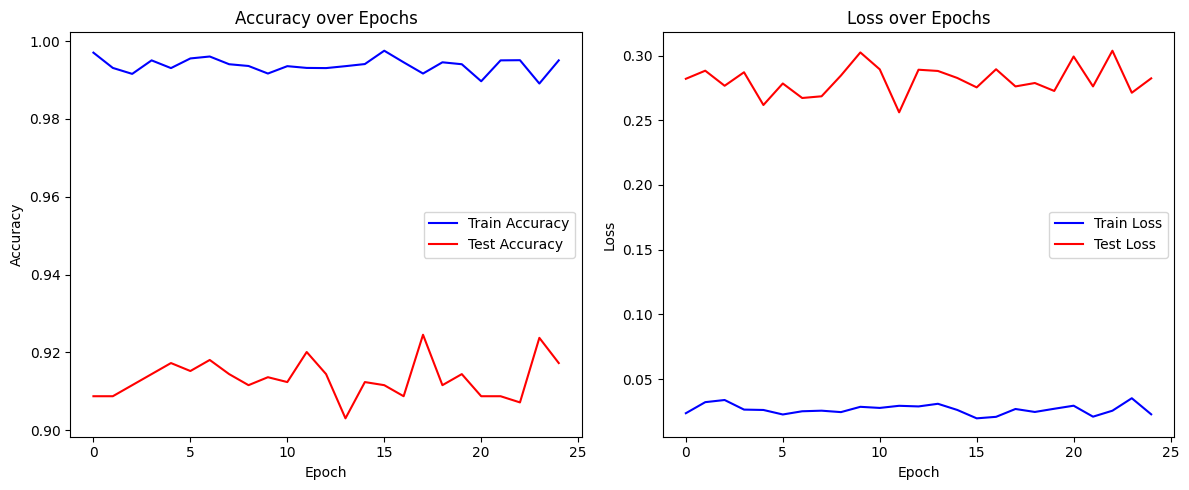

In [72]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(trainacc, label='Train Accuracy', c='b')
plt.plot(testacc, label='Test Accuracy', c='r')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(trainloss, label='Train Loss', c='b')
plt.plot(testloss, label='Test Loss', c='r')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model0(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


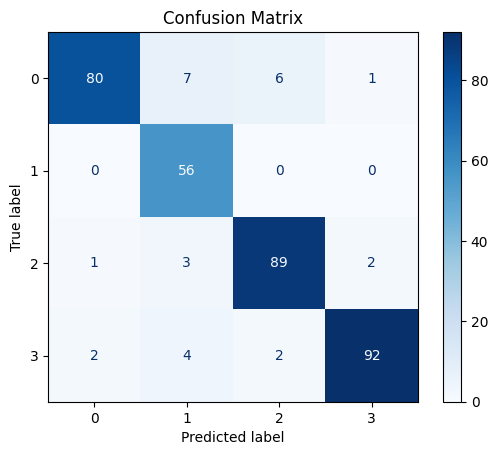

In [74]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Optional: nicer color
plt.title("Confusion Matrix")
plt.show()
